In [ ]:
!pip uninstall numpy matplotlib scipy -y
!pip install "numpy<2.0" matplotlib scipy

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import configparser
from huggingface_hub import hf_hub_download

import torch
from torch.utils.data import random_split

import sys
import time

setpaths_dir = "../setpaths"
sys.path.append(setpaths_dir)
from setpaths import setpaths
libpath, datpath, resultpath, basepath = setpaths(setpaths_dir)

# Add the correct paths
actual_project_root = ".."  # /home/ubuntu/Unrolled-DOT
actual_lib_path = "../lib"  # /home/ubuntu/Unrolled-DOT/lib

sys.path.insert(0, os.path.abspath(actual_project_root))
sys.path.insert(0, os.path.abspath(actual_lib_path))

# Now try the importnvidia-smi
#from utils import getDatasetMat, train_model # if on lambda instance
from lib.utils import getDatasetMat, train_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch

print("🧠 PyTorch CUDA Check")
print("---------------------")
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
    print("GPU Device Name:", torch.cuda.get_device_name(0))
    print("Current CUDA Device Index:", torch.cuda.current_device())
else:
    print("⚠️  No GPU available for PyTorch.")

In [7]:
rand_seed = 0
np.random.seed(rand_seed)
torch_seed = torch.manual_seed(rand_seed)

GPUID = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPUID)

#### Load training and reconstruction parameters from configuration

In [8]:
# configname = "tof_EML_dot_train_settings"
configname = "exp_vgg_unet"
# configname = "tof_dot_mismatch_settings"
# configname = "tof_dot_confocal_settings"

fullconfigpath = os.path.join("settings", configname + '.ini')
config = configparser.ConfigParser()
_ = config.read(fullconfigpath)

# Set files to read from
nTest = int(config["Settings"]["nTest"])
batch_sz = int(config["Settings"]["batch_sz"])
nEpochs = int(config["Settings"]["nEpochs"])
nLayers = int(config["Settings"]["nLayers"])
LR = float(config["Settings"]["LR"])
scale_initial_val = LR
lam1 = config.get("Settings", "lam1", fallback=None)
untied = config["Settings"].getboolean("untied")
lossFunc = config["Settings"]["lossFunc"]
showEvery = int(config["Settings"]["showEvery"])
measNormalization = float(config["Settings"]["measNormalization"])
loadFname = config["Settings"]["loadFname"]
datVarName = config["Settings"]["datVarName"]
actfunc = config["Settings"]["actfunc"]
vgg_weight = float(config["Settings"]["vgg_weight"])
unet_nfilts = int(config["Settings"]["unet_nfilts"])
displayIndices = [int(i) for i in config["Settings"]["displayIndices"].split(',')]
save_intermed = config["Settings"].getboolean("save_intermed", fallback=False)

setJ = False
if "JVarName" in config["Settings"]:
    JVarName = config["Settings"]["JVarName"]
    J_scale = float(config["Settings"]["J_scale"])
    setJ = True

#### Set up model and prepare for training

In [10]:
savepath = os.path.join(resultpath, 'exp')

if untied:
    untied_str = 'T'
else:
    untied_str = 'F'
if vgg_weight > 0:
    vgg_str = 'T'
else:
    vgg_str = 'F'
    
model_savename = "model_%s_%s_NL=%d_nEpoch=%d_lossFunc=%s_untied=%s_vgg=%s_unet_nfilts=%d_act=%s" % (loadFname, configname, nLayers, nEpochs, lossFunc, untied_str, vgg_str, unet_nfilts, actfunc)
intermed_path = os.path.join(savepath, 'intermed_' + model_savename)

In [5]:
# Define file info
repo_id = "prajaktakini/human_protein_atlas_cells_dataset" 
filename = "hf_microscopy_dataset_with_maxnormalize.mat"
local_dir = datpath  # your existing path variable

# Download from Hugging Face Hub
local_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    repo_type="dataset",
    local_dir=local_dir,
    local_dir_use_symlinks=False
)

print("✅ File downloaded to:", local_path)

/opt/anaconda3/envs/unrolled-dot-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


✅ File downloaded to: ../Unrolled-DOT-files/datapath/hf_microscopy_dataset.mat


Started training model
Here 1
Here 2
Inside lista class
Inside lista class 1
Inside lista class 2
Init vars
Init vars 2
Init vars 3
Init vars 4
Init vars 5
Init vars 6
Init vars 7
Init vars 9
Inside lista class 3
0
Init vars
Init vars 2
Init vars 3
Init vars 4
Init vars 5
Init vars 6
Init vars 7
Init vars 9
Inside lista class 3-1
Inside lista class 3-2
Inside lista class 3-3
Inside lista class 3-4
Inside lista class 3-5
1
Init vars
Init vars 2
Init vars 3
Init vars 4
Init vars 5
Init vars 6
Init vars 7
Init vars 9
Inside lista class 3-1
Inside lista class 3-2
Inside lista class 3-3
Inside lista class 3-4
Inside lista class 3-5
2
Init vars
Init vars 2
Init vars 3
Init vars 4
Init vars 5
Init vars 6
Init vars 7
Init vars 9
Inside lista class 3-1
Inside lista class 3-2
Inside lista class 3-3
Inside lista class 3-4
Inside lista class 3-5
Inside lista class 4
Here 3
Here 4
Here 5
Here 6
Here 7
Loaded full train and test data


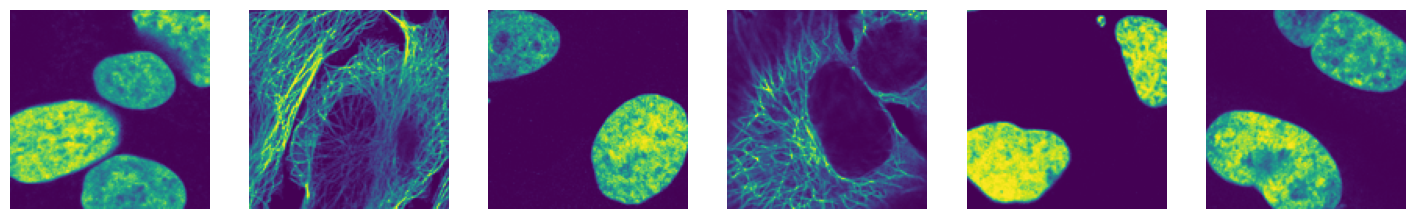

Epoch: 0
training batch started
loss 58.881597366633486


In [ ]:
# Load in data              # Just the filename without .mat
loadFpath = os.path.join(datpath, loadFname + '.mat')

if setJ:
    full_dataset, trainInds, testInds, J_mat = getDatasetMat(matpath=loadFpath, nTest=nTest, measNormalization=measNormalization, datVarName=datVarName, Jname=JVarName)
    J_init = J_mat * (J_scale / np.amax(J_mat))
else:
    full_dataset, trainInds, testInds = getDatasetMat(matpath=loadFpath, nTest=nTest, measNormalization=measNormalization, datVarName=datVarName)
    J_init = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dict = {"nLayers": nLayers,
              "scale_mag": scale_initial_val,
              "lam1": lam1,
              "actfunc": actfunc,
              "LR": LR,
              "batch_sz": batch_sz,
              "nEpochs": nEpochs,
              "showEvery": showEvery,
              "untied": untied,
              "lossFunc": lossFunc,
              "vgg_weight": vgg_weight,
              "unet_nfilts": unet_nfilts,
              "measNormalization": measNormalization,
             }

if save_intermed:
    if not (os.path.isdir(intermed_path)):
        os.makedirs(intermed_path)
    train_dict['intermed_path'] = intermed_path

model, epoch_arr, train_losses, test_losses, misc_out = train_model(dataset_in=full_dataset, 
                                                        train_d=train_dict, dev=device, A=J_init, visInds=displayIndices)


In [ ]:
# Test results

Y_test_torch, truthIms_torch = full_dataset.getFullTestSet()
_, _, _, imY, imX = full_dataset.getDims()
nIms = Y_test_torch.shape[1]

model = model.to('cpu')
Y_test_torch = Y_test_torch.cpu()
if unet_nfilts > 0:
    unet = misc_out['unet'].to('cpu')

starttime = time.perf_counter()
reconIms = model(Y_test_torch)
if unet_nfilts > 0:
    reconIms = unet(reconIms)
finishtime = time.perf_counter()
reconTime = finishtime - starttime

reconIms_np = np.reshape(reconIms.detach().numpy(), (imY, imX, nIms))
truthIms_np = truthIms_torch.cpu().detach().numpy()

In [ ]:
if not (os.path.isdir(savepath)):
    os.makedirs(savepath)

fullsavepath_model = os.path.join(savepath, model_savename + '.pt')

pydict = {
    "full_dataset": full_dataset,
    "train_dict": train_dict,
    "model": model,
    "epoch_arr": epoch_arr, 
    "train_losses": train_losses,
    "test_losses": test_losses,
    "trainInds": trainInds,
    "testInds": testInds,
}
for k in misc_out:
    pydict[k] = misc_out[k]

matdict = {
    "epoch_arr": epoch_arr, 
    "train_losses": train_losses,
    "test_losses": test_losses,
    "trainInds": trainInds,
    "testInds": testInds,
    "reconIms_np": reconIms_np,
    "truthIms_np": truthIms_np,
    "runtime_arr": misc_out["runtime_arr"],
}

torch.save(pydict, fullsavepath_model)

fullsavepath_mat = os.path.join(savepath, model_savename + '.mat')
savemat(fullsavepath_mat, matdict)

print("Saved model to: %s" % fullsavepath_model)